# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-20 18:19:56--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [               <=>  ] 201.24M  70.2MB/s    in 2.9s    

2024-10-20 18:19:59 (70.2 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [7]:
set_random_seed(42)

In [8]:
#импортируем RIDGE из Sklearn
from sklearn.linear_model import Ridge
#также импортируем RMSE
from sklearn.metrics import mean_squared_error

In [9]:
#обучим scaler на X_train
scaler.fit(X_train)
#Применим обученный scaler для нормировки наших данных
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#инициализируем Ridge()
model = Ridge()

#обучим моодель на нормированных данных
model.fit(X_train_scaled, y_train)
#получим предсказания модели
y_pred = model.predict(X_test_scaled)

#Посчитаем значение ошибки
rmse_for_model = np.sqrt(mean_squared_error(y_pred, y_test))
#Выведем ошибку
print(f"RMSE:{rmse_for_model}")

RMSE:9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [10]:
#Посчитаем среднее значение предсказаний
y_train_mean = np.mean(y_train)
#Создадим массив, таргетами которого будет среднне значение, а по размерам он будет такой же как y_test
y_new = np.full_like(y_test, y_train_mean)

#Получим значение ошибки при константе

best_rmse_metric = np.sqrt(mean_squared_error(y_new, y_test))
print(f'RMSE on const:{best_rmse_metric}')

RMSE on const:10.863228020678134


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
#Импортируем Dataloader
from torch.utils.data import DataLoader

In [12]:
#Возьмем часть выборки и разделим ее на train и test
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 10000
test_size = 50000
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:train_size+test_size]
y_test = y[train_size:train_size+test_size]

In [13]:
set_random_seed(42)

In [14]:
#Также отнормируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
#Преобразуем наши данные в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
#y_train перевернем и сделаем столбцом
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [16]:
#Напишем модель
class LinearRegression(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.fc = nn.Linear(in_features, out_features)

  def forward(self, x):
    output = self.fc(x)
    return output

In [17]:
#Инициализируем модель
set_random_seed(42)
model = LinearRegression(X_train.shape[1], 1)

In [18]:
#Напишем цикл обучения
EPOCHS = 10
lr = 0.01


#Создадим массивы для подсчета лоссов
train_losses = []
test_losses = []
train_rmse = []
test_rmse = []

for epoch in range(EPOCHS):
  #обнуляем градиенты, чтобы не складывались
  model.zero_grad()

  #получим предсказания
  y_pred = model(X_train_tensor)

  #Посчитаем лосс
  loss = torch.mean((y_pred - y_train_tensor)**2)

  #посчитаем градиенты
  loss.backward()

  with torch.no_grad():
    for param in model.parameters():
      param -= lr*param.grad

  #запомним лосс
  train_losses.append(loss.item())

  #Посчитаем метрику и сохраним ее
  rmse_train = torch.sqrt(torch.mean((y_pred - y_train_tensor)**2)).item()
  train_rmse.append(rmse_train)

  #Сделаем тоже самое на тестовой выборке
  with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = torch.mean((y_pred_test - y_test_tensor)**2).item()
    test_losses.append(test_loss)

    rmse_test = torch.sqrt(torch.mean((y_pred_test - y_test_tensor)**2)).item()
    test_rmse.append(rmse_test)

  print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Train RMSE: {rmse_train:.4f}, Test RMSE: {rmse_test}")


Epoch 1/10, Train Loss: 3995718.5000, Test Loss: 3834669.2500, Train RMSE: 1998.9293, Test RMSE: 1958.231201171875
Epoch 2/10, Train Loss: 3837490.7500, Test Loss: 3682787.2500, Train RMSE: 1958.9514, Test RMSE: 1919.0589599609375
Epoch 3/10, Train Loss: 3685529.2500, Test Loss: 3536919.5000, Train RMSE: 1919.7732, Test RMSE: 1880.669921875
Epoch 4/10, Train Loss: 3539584.5000, Test Loss: 3396828.7500, Train RMSE: 1881.3783, Test RMSE: 1843.0487060546875
Epoch 5/10, Train Loss: 3399420.0000, Test Loss: 3262285.0000, Train RMSE: 1843.7516, Test RMSE: 1806.1796875
Epoch 6/10, Train Loss: 3264806.5000, Test Loss: 3133069.7500, Train RMSE: 1806.8776, Test RMSE: 1770.0479736328125
Epoch 7/10, Train Loss: 3135523.0000, Test Loss: 3008971.0000, Train RMSE: 1770.7408, Test RMSE: 1734.6385498046875
Epoch 8/10, Train Loss: 3011359.7500, Test Loss: 2889786.7500, Train RMSE: 1735.3270, Test RMSE: 1699.937255859375
Epoch 9/10, Train Loss: 2892113.0000, Test Loss: 2775322.2500, Train RMSE: 1700.6213

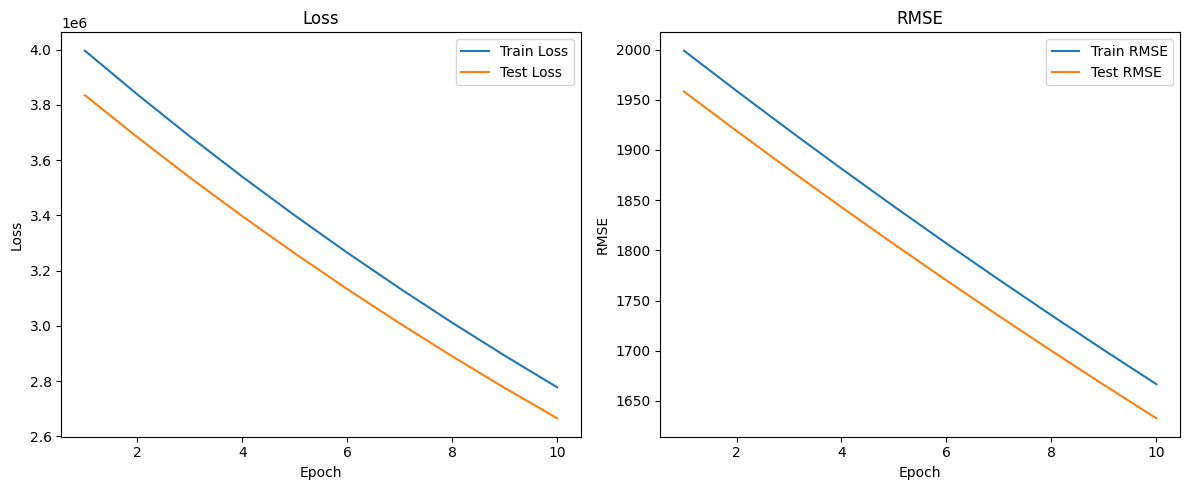

In [19]:
# График лоссов
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# График метрик
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), train_rmse, label='Train RMSE')
plt.plot(range(1, EPOCHS+1), test_rmse, label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE')
plt.legend()

plt.tight_layout()
plt.show()


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [20]:
#Импортируем Dataset
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

In [21]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
scaler_for_target = MinMaxScaler()

y_normilized = scaler_for_target.fit_transform(y.reshape(-1, 1))

In [24]:
y_normilized

array([[0.88764045],
       [0.88764045],
       [0.88764045],
       ...,
       [0.94382022],
       [0.94382022],
       [0.93258427]])

In [25]:
y_train_scaled = y_normilized[:train_size]
y_test_scaled = y_normilized[train_size:]

In [26]:
#Напишем Dataset для наших данных
class YearDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [27]:
#Напишем саму модель
class YearPredictorNet(nn.Module):
  def __init__(self, input_features):
    super().__init__()
    self.fc1 = nn.Linear(input_features, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.6)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.dropout(x)
    res = self.fc5(x)
    return res

In [28]:
set_random_seed(42)

In [29]:
train_set = YearDataset(X_train_scaled, y_train_scaled) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
train_loader = DataLoader(train_set, shuffle=True, batch_size=64) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

test_set = YearDataset(X_test_scaled, y_test_scaled)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
test_loader = DataLoader(test_set, batch_size = 64)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

model = YearPredictorNet(X_train_scaled.shape[1]) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = nn.MSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

EPOCHS = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

KeyboardInterrupt: 

In [30]:
#импортируе tqdm для понимая насколько далеко мы прдвинулись
from tqdm.notebook import tqdm

In [31]:
def plot_losses(train_losses, test_losses, train_rmse, test_rmse):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(train_rmse) + 1), train_rmse, label='train')
    axs[1].plot(range(1, len(test_rmse) + 1), test_rmse, label='test')
    axs[1].set_ylabel('RMSE')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [32]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    train_loss, train_rmse = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Обратное преобразование нормализации
        y_pred_unscaled = scaler_for_target.inverse_transform(y_pred.cpu().detach().numpy().reshape(-1, 1))
        y_unscaled = scaler_for_target.inverse_transform(y.cpu().numpy().reshape(-1, 1))

        # Вычисление RMSE на оригинальном масштабе
        rmse = np.sqrt(np.mean((y_pred_unscaled - y_unscaled) ** 2))
        train_rmse += rmse

    train_loss /= len(dataloader)
    train_rmse /= len(dataloader)
    return train_loss, train_rmse

In [33]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,):
    test_loss, test_rmse = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Обратное преобразование нормализации
            y_pred_unscaled = scaler_for_target.inverse_transform(y_pred.cpu().numpy().reshape(-1, 1))
            y_unscaled = scaler_for_target.inverse_transform(y.cpu().numpy().reshape(-1, 1))

            # Вычисление RMSE на оригинальном масштабе
            rmse = np.sqrt(np.mean((y_pred_unscaled - y_unscaled) ** 2))
            test_rmse += rmse

    test_loss /= len(dataloader)
    test_rmse /= len(dataloader)
    return test_loss, test_rmse

In [34]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.MSELoss(),
          epochs: int = 5):
  results = {
      "train_loss": [],
      "train_rmse": [],
      "test_loss": [],
      "test_rmse": []
  }

  for epoch in tqdm(range(epochs)):
    train_loss, train_rmse = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer)
    test_loss, test_rmse = test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_fn=loss_fn)
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_rmse: {train_rmse:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_rmse: {test_rmse:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_rmse"].append(train_rmse)
    results["test_loss"].append(test_loss)
    results["test_rmse"].append(test_rmse)

  return results

In [ ]:
set_random_seed(42)

train_set = YearDataset(X_train_scaled, y_train_scaled) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
train_loader = DataLoader(train_set, shuffle=True, batch_size=64) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

test_set = YearDataset(X_test_scaled, y_test_scaled)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
test_loader = DataLoader(test_set, batch_size = 64)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

model = YearPredictorNet(X_train_scaled.shape[1]).to(device) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
loss_fn = nn.MSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ


model_results = train(model, train_loader, test_loader, optimizer, epochs=10)


In [ ]:
plot_losses(model_results['train_loss'], model_results['train_rmse'], model_results['test_loss'], model_results['test_rmse'])

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

# Что использовал?

По сравнению с первым заданием в архитектуру модели были добавлены еще пару полносвязных слоев

----
Для того чтобы модель не переобучалась был добавлен dropout, который "выключает" часть нейронов, чтобы снизить зависимость нейронов друг от друга. Изначально dropout я выставил на уровне 0.3.

----
Также использовал learning_rate, изначально установил уго на уровне = 0.001.

----
В качестве последней регуляризации для предотвращения переобучения была использована weight_deacy = 1e-5

----
В итоге мы получили такие графики


In [ ]:
#Напишем саму модель
class YearPredictorNet_exp1(nn.Module):
  def __init__(self, input_features):
    super().__init__()
    self.fc1 = nn.Linear(input_features, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.dropout(x)
    res = self.fc5(x)
    return res

In [ ]:
model = YearPredictorNet_exp1(X_train_scaled.shape[1]).to(device) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
loss_fn = nn.MSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ


model_results = train(model, train_loader, test_loader, optimizer, epochs=10)

In [ ]:
plot_losses(model_results['train_loss'], model_results['train_rmse'], model_results['test_loss'], model_results['test_rmse'])

С такими гиперпараметрами мы получаем как раз необходимое качество для данной задачи. Но я стал останавливаться на данном эксперименте и решил попробовать еще поиграться с гиперпараметрами.

----

Для начала я поменял значение learning_rate = 0.05. Посмотрим, что получилось:


In [ ]:
#Напишем саму модель
class YearPredictorNet_exp2(nn.Module):
  def __init__(self, input_features):
    super().__init__()
    self.fc1 = nn.Linear(input_features, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.dropout(x)
    res = self.fc5(x)
    return res

In [ ]:
model = YearPredictorNet_exp2(X_train_scaled.shape[1]).to(device) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
loss_fn = nn.MSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ


model_results = train(model, train_loader, test_loader, optimizer, epochs=10)

In [ ]:
plot_losses(model_results['train_loss'], model_results['train_rmse'], model_results['test_loss'], model_results['test_rmse'])

Получаем ситуацию, когда модель на каких-то эпохах обучается хорошо, а на каких-то показывает ужасное качество, скорее всего из-за большого шага обучения.

----
Я решил не менять LR, а увеличить значение dropout, может быть модель станет лучше обобщать при большей вероятности отключения нейронов.
зменим помимо leraning_rate и dropout = 0.6, получаем такие графики:

In [ ]:
#Напишем саму модель
class YearPredictorNet_exp3(nn.Module):
  def __init__(self, input_features):
    super().__init__()
    self.fc1 = nn.Linear(input_features, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.6)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.dropout(x)
    res = self.fc5(x)
    return res

In [ ]:
model = YearPredictorNet_exp3(X_train_scaled.shape[1]).to(device) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
loss_fn = nn.MSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ


model_results = train(model, train_loader, test_loader, optimizer, epochs=10)

In [ ]:
plot_losses(model_results['train_loss'], model_results['train_rmse'], model_results['test_loss'], model_results['test_rmse'])

Получили качество лучше, чем в предыдущем эксперименте, но оно не сравниться с первым. Поэтому для следующего эксперимента уменьшим длину шага и оставим dropout на том же уровне.

----
Dropout = 0.6, lr = 0.001.

In [ ]:
#Напишем саму модель
class YearPredictorNet_exp4(nn.Module):
  def __init__(self, input_features):
    super().__init__()
    self.fc1 = nn.Linear(input_features, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 1)
    self.dropout = nn.Dropout(0.6)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = F.relu(self.fc4(x))
    x = self.dropout(x)
    res = self.fc5(x)
    return res

In [ ]:
model = YearPredictorNet_exp4(X_train_scaled.shape[1]).to(device) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
loss_fn = nn.MSELoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ


model_results = train(model, train_loader, test_loader, optimizer, epochs=10)

In [ ]:
plot_losses(model_results['train_loss'], model_results['train_rmse'], model_results['test_loss'], model_results['test_rmse'])


# **Вывод:**
Были найдены гиперпараметры, при которых и не переобучается, и дает хорошее качество. Самое главное оставлять длину шага небольшой, а значени dropout влияет на результаты модели, но не сильно.


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

#1 вариант(каждый год рассматриваем в качестве отдельного класса)

In [43]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# Кодируем каждый год
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

num_classes = len(le.classes_)
print(f"Количество классов: {num_classes}")


In [ ]:
#Напишем Dataset для наших данных
class YearClassDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.long).squeeze()

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [98]:
train_set = YearClassDataset(X_train_scaled, y_train_encoded) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
train_loader_class = DataLoader(train_set, shuffle=True, batch_size=64) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

test_set = YearClassDataset(X_test_scaled, y_test_encoded)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
test_loader_class = DataLoader(test_set, batch_size = 64)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ


In [99]:
class YearClassificationNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [100]:
set_random_seed(42)
input_size = X_train.shape[1]
model = YearClassificationNet(input_size, num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [101]:
model(train_set[0][0].to(device))

tensor([-0.2120,  0.0588,  0.3220,  0.0462,  0.1404,  0.1240, -0.0261,  0.2508,
        -0.0545, -0.2479, -0.0025, -0.0410, -0.0302,  0.0183, -0.0789,  0.0960,
        -0.0823,  0.1290,  0.0157, -0.1763,  0.3592, -0.0521,  0.1299, -0.0432,
         0.0465, -0.0575, -0.1436,  0.1686,  0.1005, -0.1677, -0.1662,  0.0802,
        -0.0814,  0.1510,  0.0758,  0.0743, -0.1009,  0.0904, -0.0017, -0.0527,
        -0.1225,  0.0458, -0.0990, -0.1447, -0.3785,  0.1124, -0.0162,  0.0194,
        -0.0382, -0.0019, -0.0410,  0.2099,  0.2679, -0.0866, -0.0624,  0.0241,
        -0.0258, -0.0328,  0.1705, -0.1105,  0.2191,  0.1215,  0.1301, -0.1007,
        -0.1456,  0.1836,  0.0851, -0.2397, -0.3282,  0.2610, -0.0225, -0.0934,
         0.2864,  0.0079,  0.1294,  0.1694, -0.0310,  0.4567,  0.0370,  0.1840,
         0.3027, -0.0454, -0.0966,  0.1570,  0.2367,  0.0246,  0.0330,  0.0670,
        -0.0259], device='cuda:0', grad_fn=<ViewBackward0>)

In [141]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_losses_class(train_losses, test_losses):
    clear_output(wait=True)

    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))

    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')

    plt.plot(epochs, test_losses, 'ro-', label='Test Loss')

    plt.title('Training and Test Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()


In [133]:
#Поменяем train_step и test_step для задачи классификации

def train_step_classification(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  model.train()
  train_loss = 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, pred = torch.max(y_pred, 1)

  train_loss /= len(dataloader)

  return train_loss

In [118]:
def test_step_classification(model: torch.nn.Module,
                             dataloader: torch.utils.data.DataLoader,
                             loss_fn: torch.nn.Module):
  model.eval()
  test_loss, all_predictions, all_labels = 0, [], []

  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      predicted_labels = model(X)
      loss = loss_fn(predicted_labels, y)
      test_loss += loss.item()

      _, pred = torch.max(predicted_labels, 1)
      all_predictions.extend(pred.cpu().numpy())
      all_labels.extend(y.cpu().numpy())

  test_loss /= len(dataloader)
  accuracy = accuracy_score(all_labels, all_predictions)
  precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
  recall =recall_score(all_labels, all_predictions, average='macro', zero_division=0)

  return test_loss, accuracy, precision, recall

In [123]:
def train_classification(model: torch.nn.Module,
                         train_dataloader: torch.utils.data.DataLoader,
                         test_dataloader: torch.utils.data.DataLoader,
                         optimizer: torch.optim.Optimizer,
                         loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                         epochs: int = 5):
    results = {
        "train_loss": [],
        "test_loss": [],
        "test_accuracy": [],
        "test_precision": [],
        "test_recall": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss = train_step_classification(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer
        )

        test_loss, test_acc, test_prec, test_rec = test_step_classification(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn
        )

        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} |"
              f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f} | "
              f"test_prec: {test_prec:.4f} | test_rec: {test_rec:.4f}")

        # Обновление результатов
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_acc)
        results["test_precision"].append(test_prec)
        results["test_recall"].append(test_rec)

    return results


In [124]:
def test_classification(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    predicts = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing', leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device, dtype=torch.long)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicts.extend(predicted.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    predicts = np.array(predicts)
    actuals = np.array(actuals)

    # Вычисление метрик
    accuracy = accuracy_score(actuals, predicts)
    precision = precision_score(actuals, predicts, average='macro', zero_division=0)
    recall = recall_score(actuals, predicts, average='macro', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return predicts

In [125]:
assert test_classification(model, criterion, test_loader_class).shape[0] == y_test.shape[0]

Testing:   0%|          | 0/807 [00:00<?, ?it/s]

Accuracy: 0.0867
Precision: 0.0379
Recall: 0.0248


In [126]:
model = YearClassificationNet(X_train_scaled.shape[1], num_classes).to(device) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
loss_fn = nn.CrossEntropyLoss()  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ


model_results = train_classification(model, train_loader_class, test_loader_class, optimizer, loss_fn, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.2463 |test_loss: 3.1502 | test_acc: 0.0863 | test_prec: 0.0252 | test_rec: 0.0255
Epoch: 2 | train_loss: 3.1916 |test_loss: 3.1334 | test_acc: 0.0871 | test_prec: 0.0401 | test_rec: 0.0272
Epoch: 3 | train_loss: 3.1813 |test_loss: 3.1394 | test_acc: 0.0886 | test_prec: 0.0334 | test_rec: 0.0273
Epoch: 4 | train_loss: 3.1735 |test_loss: 3.1250 | test_acc: 0.0898 | test_prec: 0.0352 | test_rec: 0.0298
Epoch: 5 | train_loss: 3.1708 |test_loss: 3.1253 | test_acc: 0.0892 | test_prec: 0.0298 | test_rec: 0.0272
Epoch: 6 | train_loss: 3.1680 |test_loss: 3.1186 | test_acc: 0.0908 | test_prec: 0.0383 | test_rec: 0.0270
Epoch: 7 | train_loss: 3.1658 |test_loss: 3.1171 | test_acc: 0.0892 | test_prec: 0.0351 | test_rec: 0.0277
Epoch: 8 | train_loss: 3.1641 |test_loss: 3.1199 | test_acc: 0.0910 | test_prec: 0.0281 | test_rec: 0.0289
Epoch: 9 | train_loss: 3.1632 |test_loss: 3.1159 | test_acc: 0.0903 | test_prec: 0.0429 | test_rec: 0.0277
Epoch: 10 | train_loss: 3.1612 |test_

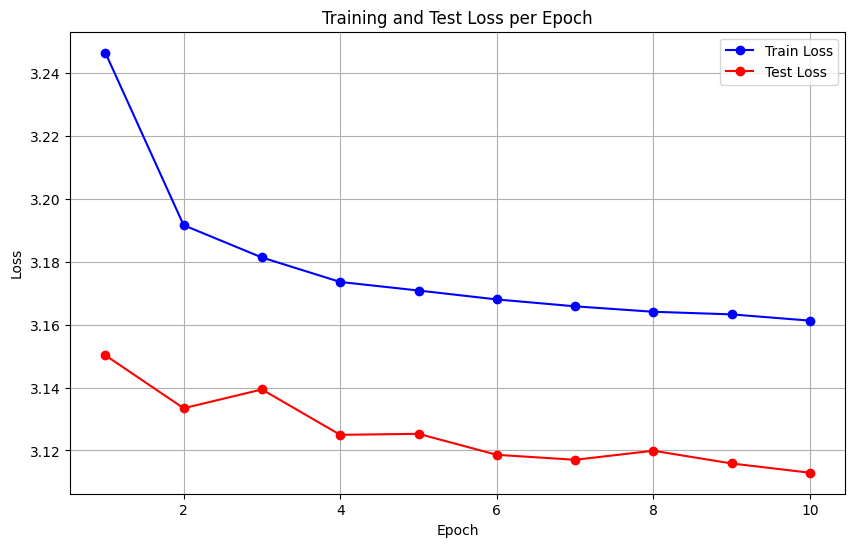

In [142]:
plot_losses_class(model_results['train_loss'], model_results['test_loss'])

#2 вариант(Рассматриваем не каждый год в отдельности, а годы по бинам)

In [35]:
class YearPredictorbin(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.6)
        self.fc4 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [36]:
#Изменим train, чтобы работало с кросс-энтропией
def train_classification(model, optimizer, criterion, train_loader, test_loader, num_epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device, dtype=torch.long)  # Убедимся, что targets имеют правильный тип

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Оценка на валидационной выборке
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device, dtype=torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item() * inputs.size(0)
            val_loss = val_running_loss / len(test_loader.dataset)
            val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

In [37]:
def test_classification(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    predicts = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing', leave=False):
            inputs = inputs.to(device)
            targets = targets.to(device, dtype=torch.long)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predicts.extend(predicted.cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    predicts = np.array(predicts)
    actuals = np.array(actuals)

    # Вычисление метрик
    accuracy = accuracy_score(actuals, predicts)
    precision = precision_score(actuals, predicts, average='macro', zero_division=0)
    recall = recall_score(actuals, predicts, average='macro', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return predicts

In [38]:
#Разобьем таргет на 10 классов
bins = np.linspace(y_train.min(), y_train.max(), 11)
y_train_binned = np.digitize(y_train, bins) - 1
y_test_binned = np.digitize(y_test, bins) - 1

num_classes = 10

In [39]:
num_bins = 10
y_train_binned = pd.cut(y_train, bins=num_bins, labels=False, include_lowest=True)
y_test_binned = pd.cut(y_test, bins=num_bins, labels=False, include_lowest=True)

# Проверка максимального значения после разбиения
print(f"Максимальный индекс класса в y_train_binned: {y_train_binned.max()}")
print(f"Максимальный индекс класса в y_test_binned: {y_test_binned.max()}")

Максимальный индекс класса в y_train_binned: 9
Максимальный индекс класса в y_test_binned: 9


In [40]:
train_set = YearDataset(X_train_scaled, y_train_binned) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
train_loader = DataLoader(train_set, shuffle=True, batch_size=64) # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

test_set = YearDataset(X_test_scaled, y_test_binned)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
test_loader = DataLoader(test_set, batch_size = 64)  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [41]:
set_random_seed(42)

input_size = X_train.shape[1]
model = YearPredictorbin(input_size, num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [44]:
assert test_classification(model, criterion, test_loader).shape[0] == y_test.shape[0]

Testing:   0%|          | 0/807 [00:00<?, ?it/s]

Accuracy: 0.0069
Precision: 0.0133
Recall: 0.1117


Epoch 1/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [1/10], Train Loss: 1.5569, Val Loss: 1.3261


Epoch 2/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [2/10], Train Loss: 1.7424, Val Loss: 1.3317


Epoch 3/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [3/10], Train Loss: 1.7432, Val Loss: 1.3273


Epoch 4/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [4/10], Train Loss: 1.6127, Val Loss: 1.3270


Epoch 5/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [5/10], Train Loss: 1.5771, Val Loss: 1.3329


Epoch 6/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [6/10], Train Loss: 1.5113, Val Loss: 1.3381


Epoch 7/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [7/10], Train Loss: 1.6694, Val Loss: 1.3301


Epoch 8/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [8/10], Train Loss: 1.6436, Val Loss: 1.3288


Epoch 9/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [9/10], Train Loss: 1.5974, Val Loss: 1.3372


Epoch 10/10:   0%|          | 0/7246 [00:00<?, ?it/s]

Epoch [10/10], Train Loss: 1.7147, Val Loss: 1.3559


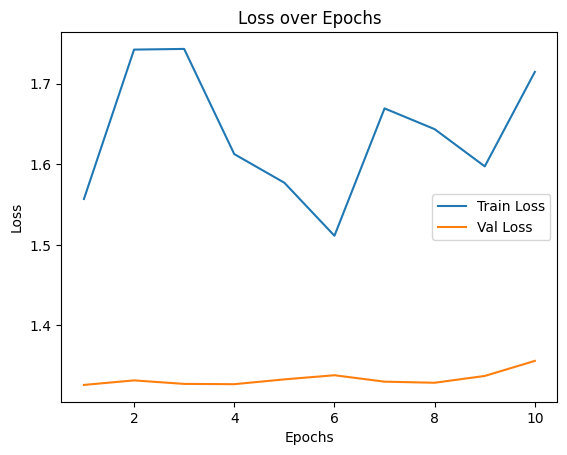

Testing:   0%|          | 0/807 [00:00<?, ?it/s]

Accuracy: 0.5193
Precision: 0.0853
Recall: 0.1000


In [45]:
train_classification(model, optimizer, criterion, train_loader, test_loader)

# Тестирование модели
test_predictions = test_classification(model, criterion, test_loader)

# **Что было сделано?**


*   Поменял выход модели, вместо 1 поставил колчиество классов на выходе
*   Добавил расчет Accuracy, Precision, Recall для отслеживания после каждой эпохи
....




# **Сравнение моделей**


1. Каждый год рассматривается как отдельный класс
----
При рассмотрении каждого года как отдельного класса мы получаем 89 классов. Получается, что модель классификации должна прогнозировать класс для каждого логита, выбирая среди 89 классов, что довольно-таки много.
В итоге, как мы видим это сказывается на метриках.
Accuracy: 0.0719
Precision: 0.0009
Recall: 0.0128
Метрики довольно слабые и модель зачастую неправильно классифицирует объект.
Это может быть связано с дисбалансом классов.

----
2. Разбиваем года на 10 бинов
----
В случае разделения всех таргетов на 10 бинов, мы видим улучшение метрик.
Accuracy: 0.5193
Precision: 0.0519
Recall: 0.1000
В данном случае у модели меньше вероятность ошибится, соответсвенно мы и получили лучшие метрики по сравнению с 1 вариантом

----

3. Регрессия
----
Решение задачи с помощью регрессии позволяет более точно предсказывать год без привязки к какому-то классу
Для нашей задачи, по моему мнению, нам больше подходит именно регрессия, поскольку перед нами была поставлена задача предсказать год выпуска песни по ее характеристикам, а регрессия именно эту задачу и выполняет

----

